In [56]:
import os
import re
import itertools
import pandas as pd
import matplotlib.pyplot as plt

In [57]:
dir_path = "dumps/experiments"
image_dir = "/home/nik/Projects/magistrska-naloga/thesis-paper/images"
table_dir = "/home/nik/Projects/magistrska-naloga/thesis-paper/tables"

In [58]:
def extract_results_from_dir(dir_path: str):
    results = []
    for file in os.listdir(dir_path):
        single_results = {}
        if not file.startswith("_predictions_"):
            continue
        single_results["name"] = file.replace("_predictions_", "").replace(".txt", "")
        single, multi = extract_results_from_file(os.path.join(dir_path, file))

        (
            single_results["rec_num_examples"],
            single_results["fully_added"],
            single_results["true_positive"],
            single_results["avg_min_rank"],
            single_results["avg_min_smooth_rank"],
            single_results["avg_mean_rank"],
            single_results["avg_mean_smooth_rank"],
            single_results["class_num_examples"],
            single_results["area_under_roc"],
        ) = single[0]

        # for treshold, accuracy, precision, recall, f1, confusion_matrix in multi:
        #     single_results["treshold"] = treshold
        #     single_results["accuracy"] = accuracy
        #     single_results["precision"] = precision
        #     single_results["recall"] = recall
        #     single_results["f1"] = f1

        #     results.append(single_results)

        for treshold, accuracy, precision, recall, f1, confusion_matrix in multi:
            single_results[f"accuracy_{treshold}"] = accuracy
            single_results[f"precision_{treshold}"] = precision
            single_results[f"recall_{treshold}"] = recall
            single_results[f"f1_{treshold}"] = f1

        results.append(single_results)

    return pd.DataFrame.from_records(results)


def extract_results_from_file(file_path: str):
    with open(file_path, "r", encoding="utf-8") as f:
        data = f.read()
    return extract_results_from_string(data)


def extract_results_from_string(string: str):
    single_pattern = r"Recommender quality measures:\s+- Number of test examples: (?P<recommender_number_examples>\d+) \(fully added: (?P<recommender_fully_added>\d+)\)\s+- Proportion of predictions that are in actual neighbours: (?P<recommender_TP>.+)\s+- The average minimal rank \(>= 0\) of the actual neighbour: (?P<recommender_avg_min_rank>\d+\.\d+)\s+- The average minimal smooth rank \(>= 1.0\) of the actual neighbour: (?P<recommender_avg_min_smooth_rank>\d+\.\d+)\s+- The average mean rank \(>= 0\) of the actual neighbour: (?P<recommender_avg_mean_rank>\d+\.\d+)\s+- The average mean smooth rank \(>= 1.0\) of the actual neighbour: (?P<recommender_avg_maen_smooth_rank>\d+\.\d+)\s+Classification quality measures:\s+\* Number of examples: (?P<class_num_examples>\d+)\s+\* Threshold independent measures:\s+- area under ROC: (?P<class_area_under_ROC>\d+\.\d+)"

    multi_pattern = r"threshold = (?P<treshold>\d+\.\d+)\s*- accuracy: (?P<accuracy>\d+\.\d+)\s*- precision: (?P<precision>\d+\.\d+)\s*- recall: (?P<recall>\d+\.\d+)\s*- F1: (?P<f1>\d+\.\d+)\s*- confusion matrix: (?P<confusion_matrix>\[\[\d+, \d+], \[\d+, \d+]]) \(labels: \[0, 1]\)"

    single_pattern = re.compile(single_pattern)
    multi_pattern = re.compile(multi_pattern)

    single = re.findall(single_pattern, string)
    multi = re.findall(multi_pattern, string)
    return single, multi

In [59]:
def plot_main_four(
    data: pd.DataFrame,
    cases: dict,
    filename: str = None,
    legend_position: tuple[float] = (0.6, 0),
    legend_offset: float = {"bottom": 0.2},
    y_scales: list[list[str]] = [["linear", "linear"], ["linear", "linear"]],
):
    ticks = [16, 32, 64, 128]
    fig, axs = plt.subplots(2, 2)

    for label, case in cases.items():

        if data[case].empty:
            continue

        axs[0, 0].plot(
            data[case]["embeddings_size"],
            data[case]["avg_min_rank"],
        )
        axs[0, 0].set(ylabel="Povprečni minimalni rang", xticks=ticks)

        axs[0, 1].plot(
            data[case]["embeddings_size"],
            data[case]["avg_mean_rank"],
        )
        axs[0, 1].set(ylabel="Povprečni povprečni rang", xticks=ticks)

        axs[1, 0].plot(
            data[case]["embeddings_size"],
            data[case]["f1_0.5"],
        )
        axs[1, 0].set(
            ylabel="F1 vrednost (prag 0.5)", xticks=ticks, xlabel="Velikost vložitve"
        )

        axs[1, 1].plot(
            data[case]["embeddings_size"],
            data[case]["area_under_roc"],
            label=label,
        )
        axs[1, 1].set(
            ylabel="Ploščina pod ROC", xticks=ticks, xlabel="Velikost vložitve"
        )

    fig.legend(bbox_to_anchor=legend_position)
    fig.tight_layout()
    fig.subplots_adjust(**legend_offset)
    # Setting axis scales
    for a, s in zip(axs, y_scales):
        for ax, scale in zip(a, s):
            ax.set_yscale(scale)
    if filename:
        plt.savefig(
            os.path.join(image_dir, f"{filename}.png"), bbox_inches="tight", dpi=400
        )
    plt.show()

In [60]:
results = extract_results_from_dir(dir_path)

In [61]:
results[results.columns.difference(["name", "rec_num_examples", "fully_added"])] = (
    results[results.columns.difference(["name", "rec_num_examples", "fully_added"])]
).astype(float)

In [62]:
results = results.sort_values("area_under_roc", ascending=False)
results.head(5)

,name,rec_num_examples,fully_added,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,...,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9,f1_0.9
17,Node2VecEdgeEmbeddingRecommender_0_p_to_keep_0...,2916,2916,0.251372,4.522977,1.002205,156.752127,1.297452,39165.0,0.991231,...,0.985767,0.926277,0.924959,0.993365,0.856861,0.920077,0.859134,0.997621,0.722281,0.837912
24,GNN_p_to_keep_0.1_asts_agda_128_hidden_[64]_ou...,2916,2916,0.032373,44.719479,1.000987,474.465494,1.564154,39165.0,0.972314,...,0.965608,0.891028,0.907673,0.960640,0.851745,0.902921,0.874812,0.978339,0.768678,0.860928
4,"GNN_p_to_keep_0.1_asts_agda_64_hidden_[32, 32]...",2916,2916,0.027366,58.149177,1.001047,551.183986,1.627875,39165.0,0.968661,...,0.960796,0.891044,0.893655,0.954222,0.828800,0.887100,0.864292,0.975607,0.749531,0.847756
102,GNN_p_to_keep_0.1_asts_agda_32_hidden_[64]_out...,2916,2916,0.043553,36.693416,1.000409,535.487496,1.588039,39165.0,0.968326,...,0.961353,0.882688,0.892685,0.960636,0.820747,0.885198,0.859083,0.981582,0.734235,0.840080
69,"GNN_p_to_keep_0.1_asts_agda_128_hidden_[64, 64...",2916,2916,0.033813,51.640604,1.003441,550.866952,1.642289,39165.0,0.968022,...,0.960188,0.886483,0.899706,0.960033,0.835841,0.893642,0.867331,0.978425,0.753432,0.851313


## All models compared

In [63]:
print(results.iloc[[24]]["name"].to_list()[0])

GNN_p_to_keep_0.1_asts_agda_16_hidden_[64, 64]_out_64_epochs_20000


In [64]:
all_different_models = results[
    (
        results["name"]
        == "GNN_p_to_keep_0.1_asts_agda_16_hidden_[64, 64]_out_64_epochs_20000"
    )
    | ~(
        (results["name"].str.contains("GNN"))
        | (results["name"].str.contains("Code2Seq"))
    )
]

all_different_models[
    [
        "name",
        "avg_min_rank",
        "avg_min_smooth_rank",
        "avg_mean_rank",
        "avg_mean_smooth_rank",
        "area_under_roc",
        "precision_0.5",
        "recall_0.5",
        "f1_0.5",
    ]
].sort_values("avg_min_rank")

,name,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,area_under_roc,precision_0.5,recall_0.5,f1_0.5
17,Node2VecEdgeEmbeddingRecommender_0_p_to_keep_0...,4.522977,1.002205,156.752127,1.297452,0.991231,0.972466,0.948134,0.960146
101,"GNN_p_to_keep_0.1_asts_agda_16_hidden_[64, 64]...",41.926269,1.000699,742.484302,1.646034,0.955575,0.899911,0.871195,0.885320
79,TFIDFRecommender_1_p_to_keep_0.1_cityblock,95.068930,1.143217,1021.444831,1.555496,0.515752,0.988994,0.031859,0.061730
71,TFIDFRecommender_0_p_to_keep_0.1_cosine,178.269547,1.467107,3198.374223,37.845909,0.515423,0.987200,0.031252,0.060585
1,WordEmbeddingRecommender_0_p_to_keep_0.1_WordF...,301.646433,1.020225,3446.644579,1.082741,0.518512,0.993252,0.037279,0.071861
99,WordEmbeddingRecommender_1_p_to_keep_0.1_WordF...,912.447531,1.053078,6349.458652,1.166498,0.511522,0.995643,0.023147,0.045243
46,BagOfWordsRecommender_0_p_to_keep_0.1_empty,1745.773663,3.529385,8449.966257,6.617291,0.506052,0.995633,0.011548,0.022832
98,DummyRecommender_0_p_to_keep_0.1_empty,2391.360425,1.085816,8235.447339,1.384512,0.502734,0.965517,0.005673,0.011280


In [65]:
for name in all_different_models["name"]:
    print(name)

Node2VecEdgeEmbeddingRecommender_0_p_to_keep_0.1_edge_concatenation_p1.0_q1.0_vec_size32_window5_walk_len50_epo10model_rf
GNN_p_to_keep_0.1_asts_agda_16_hidden_[64, 64]_out_64_epochs_20000
WordEmbeddingRecommender_0_p_to_keep_0.1_WordFrequencyWeight.TFIDF_LOG2_COUNT-cityblock
TFIDFRecommender_1_p_to_keep_0.1_cityblock
TFIDFRecommender_0_p_to_keep_0.1_cosine
WordEmbeddingRecommender_1_p_to_keep_0.1_WordFrequencyWeight.CONSTANT-cityblock
BagOfWordsRecommender_0_p_to_keep_0.1_empty
DummyRecommender_0_p_to_keep_0.1_empty


In [108]:
model_selection = {
    "Node2VecEdgeEmbeddingRecommender_0_p_to_keep_0.1_edge_concatenation_p1.0_q1.0_vec_size32_window5_walk_len50_epo10model_rf": "node2vec",
    "GNN_p_to_keep_0.1_asts_agda_16_hidden_[64, 64]_out_64_epochs_20000": "GNN",
    "WordEmbeddingRecommender_0_p_to_keep_0.1_WordFrequencyWeight.TFIDF_LOG2_COUNT-cityblock": "fastText",
    "TFIDFRecommender_1_p_to_keep_0.1_cityblock": "TFIDF",
    "BagOfWordsRecommender_0_p_to_keep_0.1_empty": "BoW",
    "DummyRecommender_0_p_to_keep_0.1_empty": "dummy",
}
final_models = results[results["name"].isin(model_selection.keys())]

In [118]:
final_models.sort_values("avg_min_rank").to_latex(
    buf=os.path.join(table_dir, "all-comparison.tex"),
    index=False,
    column_format="lrrrrrrrr",
    columns=[
        "name",
        "avg_min_rank",
        "avg_min_smooth_rank",
        "avg_mean_rank",
        "avg_mean_smooth_rank",
        "area_under_roc",
        "precision_0.5",
        "recall_0.5",
        "f1_0.5",
    ],
    header=[
        "Ime",
        "MR",
        "SMR",
        "AR",
        "SAR",
        "ROC",
        "PREC",
        "REC",
        "F1",
    ],
    formatters={
        "name": lambda x: str(model_selection[x]),
        "avg_min_rank": lambda x: "{:.1f}".format(x),
        "avg_min_smooth_rank": lambda x: "{:.3f}".format(x),
        "avg_mean_rank": lambda x: "{:.0f}".format(x),
        "avg_mean_smooth_rank": lambda x: "{:.2f}".format(x),
        "area_under_roc": lambda x: "{:.3f}".format(x),
        "precision_0.5": lambda x: "{:.3f}".format(x),
        "recall_0.5": lambda x: "{:.3f}".format(x),
        "f1_0.5": lambda x: "{:.3f}".format(x),
    },
)

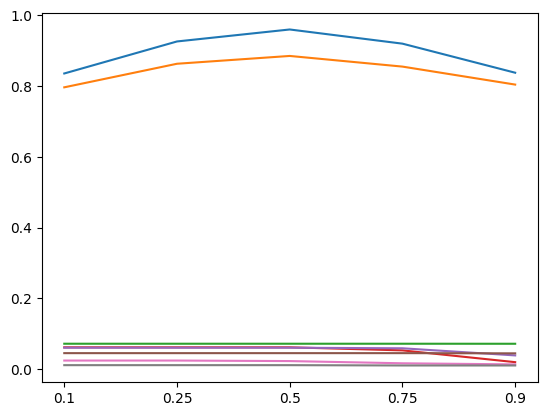

In [68]:
for name in all_different_models.name.unique():
    selection = all_different_models[all_different_models["name"]==name]
    tresholds = ["0.1", "0.25", "0.5", "0.75", "0.9"]
    scores = [selection[f"f1_{val}"] for val in tresholds]
    plt.plot(tresholds, scores, label=name)

In [69]:
GNN_results = results[results["name"].str.contains("GNN")]
other_results = results[~results["name"].str.contains("GNN")]
GNN_results

,name,rec_num_examples,fully_added,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,...,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9,f1_0.9
24,GNN_p_to_keep_0.1_asts_agda_128_hidden_[64]_ou...,2916,2916,0.032373,44.719479,1.000987,474.465494,1.564154,39165.0,0.972314,...,0.965608,0.891028,0.907673,0.960640,0.851745,0.902921,0.874812,0.978339,0.768678,0.860928
4,"GNN_p_to_keep_0.1_asts_agda_64_hidden_[32, 32]...",2916,2916,0.027366,58.149177,1.001047,551.183986,1.627875,39165.0,0.968661,...,0.960796,0.891044,0.893655,0.954222,0.828800,0.887100,0.864292,0.975607,0.749531,0.847756
102,GNN_p_to_keep_0.1_asts_agda_32_hidden_[64]_out...,2916,2916,0.043553,36.693416,1.000409,535.487496,1.588039,39165.0,0.968326,...,0.961353,0.882688,0.892685,0.960636,0.820747,0.885198,0.859083,0.981582,0.734235,0.840080
69,"GNN_p_to_keep_0.1_asts_agda_128_hidden_[64, 64...",2916,2916,0.033813,51.640604,1.003441,550.866952,1.642289,39165.0,0.968022,...,0.960188,0.886483,0.899706,0.960033,0.835841,0.893642,0.867331,0.978425,0.753432,0.851313
106,GNN_p_to_keep_0.1_asts_agda_32_hidden_[32]_out...,2916,2916,0.036831,35.393004,1.000793,542.317552,1.517847,39165.0,0.967969,...,0.966115,0.881546,0.886812,0.961311,0.807983,0.878003,0.846879,0.980831,0.710125,0.823809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43,"GNN_p_to_keep_0.1_asts_agda_32_hidden_[64, 64]...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
8,"GNN_p_to_keep_0.1_asts_agda_16_hidden_[32, 32,...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
85,"GNN_p_to_keep_0.1_asts_agda_64_hidden_[32, 32,...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000
48,"GNN_p_to_keep_0.1_asts_agda_16_hidden_[64, 64,...",2916,2916,0.000000,6949.630316,1.000000,11104.313374,1.000000,39165.0,0.500000,...,1.000000,0.670299,0.495902,0.000000,0.000000,0.000000,0.495902,0.000000,0.000000,0.000000


In [70]:
other_results

,name,rec_num_examples,fully_added,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,...,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9,f1_0.9
17,Node2VecEdgeEmbeddingRecommender_0_p_to_keep_0...,2916,2916,0.251372,4.522977,1.002205,156.752127,1.297452,39165.0,0.991231,...,0.985767,0.926277,0.924959,0.993365,0.856861,0.920077,0.859134,0.997621,0.722281,0.837912
97,Code2Seq_p_to_keep_0.1_asts_agda_128,2916,2916,0.188409,29.308985,1.013530,1505.524479,1.992161,39165.0,0.900900,...,0.957656,0.747889,0.729478,0.949843,0.489186,0.645782,0.631993,0.976063,0.276756,0.431238
70,Code2Seq_p_to_keep_0.1_asts_agda_64,2916,2916,0.188752,32.316872,1.014188,1635.044239,1.962496,39165.0,0.894260,...,0.952895,0.747081,0.728099,0.952798,0.484627,0.642471,0.630078,0.976947,0.272603,0.426263
77,Code2Seq_p_to_keep_0.1_asts_agda_32,2916,2916,0.175171,41.080247,1.020003,1859.313942,2.121852,39165.0,0.879377,...,0.952439,0.741380,0.713213,0.944717,0.457884,0.616812,0.623695,0.974228,0.260396,0.410951
94,Code2Seq_p_to_keep_0.1_asts_agda_16,2916,2916,0.177984,56.004115,1.030086,2391.255178,2.083765,39165.0,0.846209,...,0.949653,0.715829,0.684463,0.936517,0.401256,0.561804,0.614886,0.974542,0.242364,0.388188
1,WordEmbeddingRecommender_0_p_to_keep_0.1_WordF...,2916,2916,0.050480,301.646433,1.020225,3446.644579,1.082741,39165.0,0.518512,...,0.037279,0.071861,0.514567,0.993252,0.037279,0.071861,0.514541,0.993243,0.037228,0.071767
79,TFIDFRecommender_1_p_to_keep_0.1_cityblock,2916,2916,0.043141,95.068930,1.143217,1021.444831,1.555496,39165.0,0.515752,...,0.031859,0.061730,0.509511,0.990792,0.027250,0.053042,0.500906,0.994949,0.009978,0.019758
71,TFIDFRecommender_0_p_to_keep_0.1_cosine,2916,2916,0.042318,178.269547,1.467107,3198.374223,37.845909,39165.0,0.515423,...,0.031252,0.060585,0.511017,0.986842,0.030391,0.058965,0.505834,0.994911,0.019804,0.038836
99,WordEmbeddingRecommender_1_p_to_keep_0.1_WordF...,2916,2916,0.031344,912.447531,1.053078,6349.458652,1.166498,39165.0,0.511522,...,0.023147,0.045243,0.507519,0.995643,0.023147,0.045243,0.507392,0.997788,0.022844,0.044665
46,BagOfWordsRecommender_0_p_to_keep_0.1_empty,2916,2589,0.016667,1745.773663,3.529385,8449.966257,6.617291,39165.0,0.506052,...,0.012308,0.024312,0.500089,0.993976,0.008357,0.016575,0.499298,0.992593,0.006787,0.013482


In [71]:
properties = {
    "embeddings_file": [],
    "embeddings_size": [],
    "hidden_size": [],
    "out_size": [],
    "n_epochs": [],
}
for name in GNN_results["name"]:
    pattern = r"GNN_p_to_keep_0.1_asts_(?P<embedding_file>\w+)_(?P<embedding_size>\d+)_hidden_(?P<hidden_size>.+)_out_(?P<out_size>\d+)_epochs_(?P<n_epochs>\d+)"
    pattern = re.compile(pattern)
    parts = re.findall(pattern, name)
    if not parts:
        parts = [("", "", "", "", "")]
    parts = parts[0]
    for key, value in zip(properties.keys(), parts):
        properties[key].append(value)

GNN_results = GNN_results.assign(**properties)
cols = list(GNN_results.columns)
cols = cols[-5:] + cols[1:-5]
GNN_results = GNN_results[cols].drop(
    ["rec_num_examples", "fully_added", "class_num_examples"], axis=1
)
GNN_results = GNN_results[GNN_results["embeddings_size"] != ""]
GNN_results[["embeddings_size", "out_size", "n_epochs"]] = GNN_results[
    ["embeddings_size", "out_size", "n_epochs"]
].astype(int)
GNN_results = GNN_results.sort_values(["embeddings_size", "hidden_size", "out_size"])

In [72]:
code2seq_results = other_results[other_results["name"].str.contains("Code2Seq")]
code2seq_results["embeddings_size"] = code2seq_results["name"].apply(
    lambda row: int(list(str(row).split("_"))[-1])
)
cols = list(code2seq_results.columns)
cols = cols[-1:] + cols[3:-2]
code2seq_results = code2seq_results[cols]
code2seq_results

/tmp/ipykernel_4136/4028038148.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  code2seq_results["embeddings_size"] = code2seq_results["name"].apply(


,embeddings_size,true_positive,avg_min_rank,avg_min_smooth_rank,avg_mean_rank,avg_mean_smooth_rank,class_num_examples,area_under_roc,accuracy_0.5,precision_0.5,...,precision_0.25,recall_0.25,f1_0.25,accuracy_0.75,precision_0.75,recall_0.75,f1_0.75,accuracy_0.9,precision_0.9,recall_0.9
97,128,0.188409,29.308985,1.013530,1505.524479,1.992161,39165.0,0.900900,0.840087,0.857711,...,0.613505,0.957656,0.747889,0.729478,0.949843,0.489186,0.645782,0.631993,0.976063,0.276756
70,64,0.188752,32.316872,1.014188,1635.044239,1.962496,39165.0,0.894260,0.830716,0.841609,...,0.614382,0.952895,0.747081,0.728099,0.952798,0.484627,0.642471,0.630078,0.976947,0.272603
77,32,0.175171,41.080247,1.020003,1859.313942,2.121852,39165.0,0.879377,0.809166,0.823977,...,0.606894,0.952439,0.741380,0.713213,0.944717,0.457884,0.616812,0.623695,0.974228,0.260396
94,16,0.177984,56.004115,1.030086,2391.255178,2.083765,39165.0,0.846209,0.776561,0.795357,...,0.574400,0.949653,0.715829,0.684463,0.936517,0.401256,0.561804,0.614886,0.974542,0.242364


## Top 5 GNN models for different tasks


In [73]:
GNN_results.sort_values("area_under_roc", ascending=False).head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "area_under_roc"]
]

,embeddings_size,hidden_size,out_size,n_epochs,area_under_roc
24,128,[64],64,20000,0.972314
4,64,"[32, 32]",32,20000,0.968661
102,32,[64],64,20000,0.968326
69,128,"[64, 64]",64,20000,0.968022
106,32,[32],32,20000,0.967969


In [74]:
GNN_results.sort_values("area_under_roc", ascending=False).head(5).to_latex(
    buf=os.path.join(table_dir, "gnn-area-under-roc-top-5.tex"),
    index=False,
    float_format="{:.5f}".format,
    column_format="lllr",
    columns=[
        "embeddings_size",
        "hidden_size",
        "out_size",
        "area_under_roc",
    ],
    header=[
        "Vložitev",
        "Skrita plast",
        "Izhodn",
        "Ploščina pod ROC",
    ],
)

In [75]:
GNN_results.sort_values("avg_min_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_min_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_min_rank
106,32,[32],32,20000,35.393004
102,32,[64],64,20000,36.693416
78,16,"[16, 16]",32,20000,39.690672
101,16,"[64, 64]",64,20000,41.926269
11,32,"[32, 32, 32, 32]",32,20000,42.095679


In [76]:
GNN_results.sort_values("avg_min_rank").head(5).to_latex(
    buf=os.path.join(table_dir, "gnn-avg-min-rank-top-5.tex"),
    index=False,
    float_format="{:.1f}".format,
    column_format="lllr",
    columns=[
        "embeddings_size",
        "hidden_size",
        "out_size",
        "avg_min_rank",
    ],
    header=[
        "Vložitev",
        "Skrita plast",
        "Izhodn",
        "Povprečen min. rang",
    ],
)

In [77]:
GNN_results.sort_values("avg_min_smooth_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_min_smooth_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_min_smooth_rank
43,32,"[64, 64]",64,20000,1.0
40,128,"[64, 64, 64]",64,20000,1.0
48,16,"[64, 64, 64]",64,20000,1.0
23,128,"[32, 32, 32, 32, 32, 32]",32,20000,1.0
8,16,"[32, 32, 32, 32, 32, 32]",32,20000,1.0


In [78]:
GNN_results.sort_values("avg_mean_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_mean_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_mean_rank
24,128,[64],64,20000,474.465494
102,32,[64],64,20000,535.487496
106,32,[32],32,20000,542.317552
69,128,"[64, 64]",64,20000,550.866952
4,64,"[32, 32]",32,20000,551.183986


In [79]:
GNN_results.sort_values("avg_mean_rank").head(5).to_latex(
    buf=os.path.join(table_dir, "gnn-avg-mean-rank-top-5.tex"),
    index=False,
    float_format="{:.1f}".format,
    column_format="lllr",
    columns=[
        "embeddings_size",
        "hidden_size",
        "out_size",
        "avg_mean_rank",
    ],
    header=[
        "Vložitev",
        "Skrita plast",
        "Izhod",
        "Povprečen povprečni rang",
    ],
)

In [80]:
GNN_results.sort_values("avg_mean_smooth_rank").head(5)[
    ["embeddings_size", "hidden_size", "out_size", "n_epochs", "avg_mean_smooth_rank"]
]

,embeddings_size,hidden_size,out_size,n_epochs,avg_mean_smooth_rank
43,32,"[64, 64]",64,20000,1.0
40,128,"[64, 64, 64]",64,20000,1.0
85,64,"[32, 32, 32, 32, 32]",32,20000,1.0
48,16,"[64, 64, 64]",64,20000,1.0
8,16,"[32, 32, 32, 32, 32, 32]",32,20000,1.0


In [81]:
results[
    (results["name"] == "Code2Seq_p_to_keep_0.1_asts_agda_128")
    | (
        results["name"]
        == "GNN_p_to_keep_0.1_asts_agda_128_hidden_[16, 16]_out_32_epochs_20000"
    )
].to_latex(
    buf=os.path.join(table_dir, "gnn-top-vs-code2seq-and-gnn.tex"),
    index=False,
    float_format="{:.1f}".format,
    column_format="lllr",
    columns=[
        "name",
        "avg_min_rank",
        "avg_mean_rank",
        "area_under_roc",
        "f1_0.5",
    ],
    header=[
        "Ime",
        "Povprečni minimalni rang",
        "Povprečen povprečni rang",
        "Ploščina pod RO krivuljo",
        "F1 vrednost (0.5)",
    ],
)

## Comparison with all other models


## An assortment of graphs


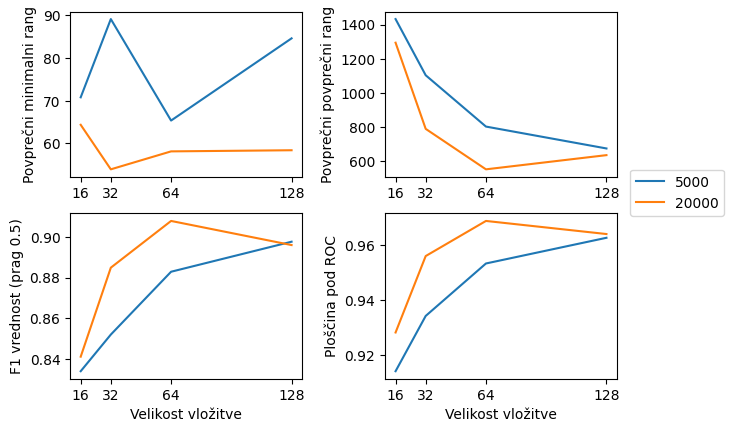

In [107]:
cases = {
    N: (
        (GNN_results["hidden_size"] == "[32, 32]")
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == N)
    )
    for N in [5000, 20000]
}

plot_main_four(GNN_results, cases, "gnn-epochs-influence", legend_position=(1.15, 0.65))

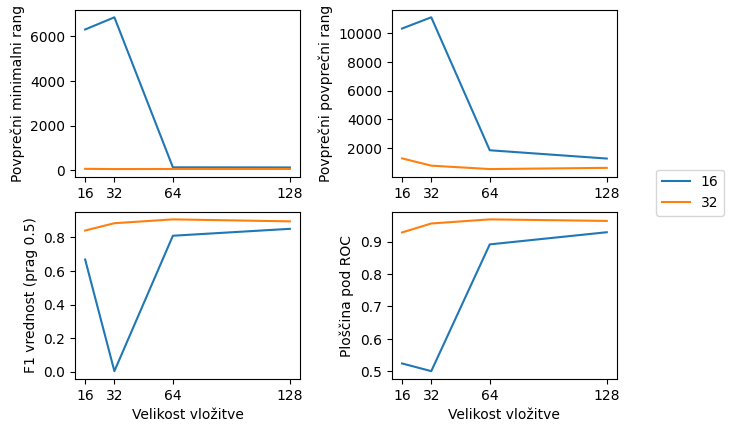

In [83]:
cases = {
    N: (
        (GNN_results["hidden_size"] == "[32, 32]")
        & (GNN_results["out_size"] == N)
        & (GNN_results["n_epochs"] == 20000)
    )
    for N in [16, 32]
}

plot_main_four(
    GNN_results, cases, "gnn-output-size-influence", legend_position=(1.15, 0.65)
)

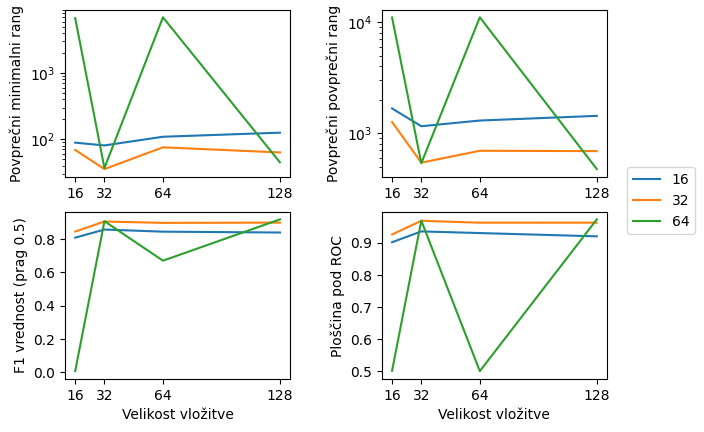

In [84]:
cases = {
    N: (
        (GNN_results["hidden_size"] == f"[{N}]")
        & (GNN_results["out_size"] == N)
        & (GNN_results["n_epochs"] == 20000)
    )
    for N in [16, 32, 64]
}

plot_main_four(
    GNN_results,
    cases,
    "gnn-hidden-size-influence",
    legend_position=(1.12, 0.655),
    y_scales=[["log", "log"], ["linear", "linear"]],
)

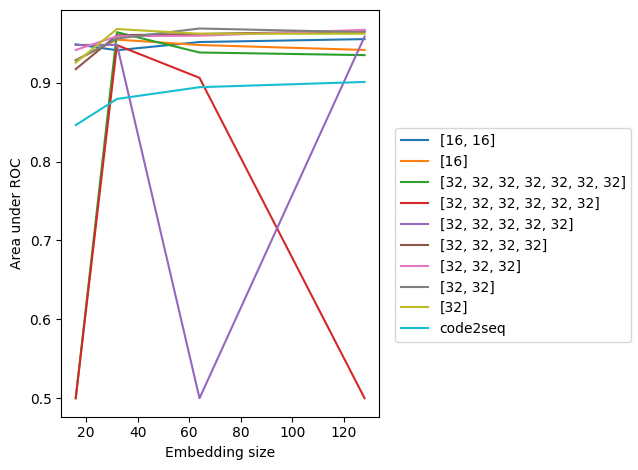

In [85]:
code2seq_results = code2seq_results.sort_values("embeddings_size")

fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=h,
    )
ax.plot(
    code2seq_results["embeddings_size"],
    code2seq_results["area_under_roc"],
    label="code2seq",
)

plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

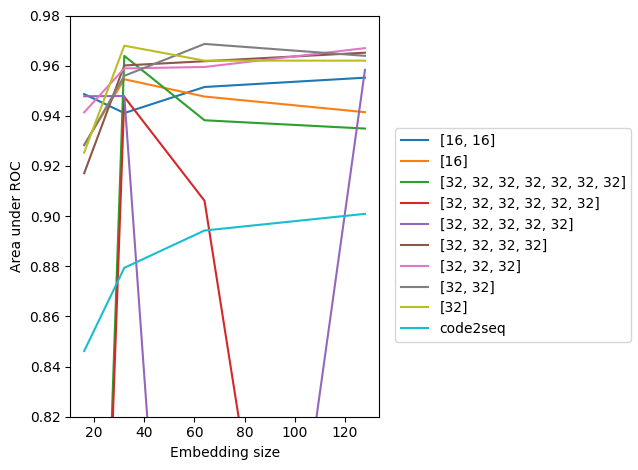

In [86]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=h,
    )
ax.plot(
    code2seq_results["embeddings_size"],
    code2seq_results["area_under_roc"],
    label="code2seq",
)

plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")
plt.ylim(0.82, 0.98)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

In [87]:
{h: "" for h in GNN_results.hidden_size.unique()}

{'[64, 64, 64]': '',
 '[64, 64]': '',
 '[16, 16]': '',
 '[16]': '',
 '[32, 32, 32, 32, 32, 32, 32]': '',
 '[32, 32, 32, 32, 32, 32]': '',
 '[32, 32, 32, 32, 32]': '',
 '[32, 32, 32, 32]': '',
 '[32, 32, 32]': '',
 '[32, 32]': '',
 '[32]': '',
 '[64]': ''}

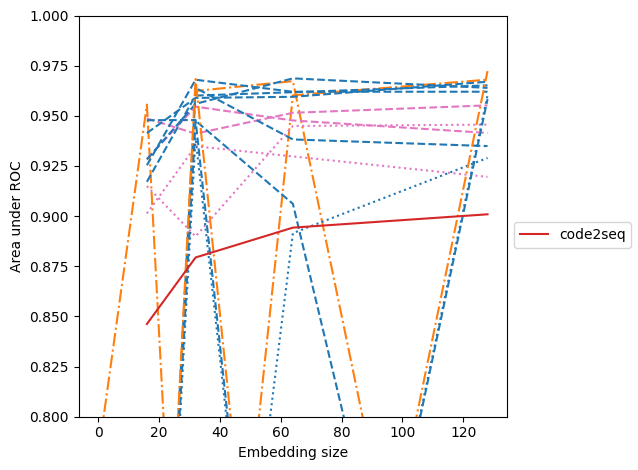

In [88]:
color_map = {
    "[64]": "tab:orange",
    "[64, 64, 64]": "tab:orange",
    "[64, 64]": "tab:orange",
    "[32, 32]": "tab:blue",
    "[32, 32, 32]": "tab:blue",
    "[32, 32, 32, 32]": "tab:blue",
    "[16]": "tab:pink",
    "[16, 16]": "tab:pink",
    "[32]": "tab:blue",
    "[32, 32, 32, 32, 32]": "tab:blue",
    "[32, 32, 32, 32, 32, 32]": "tab:blue",
    "[32, 32, 32, 32, 32, 32, 32]": "tab:blue",
}
line_map = {
    16: "dotted",
    32: "dashed",
    64: "dashdot",
}

fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)

for h, o in itertools.product(
    GNN_results.hidden_size.unique(), GNN_results.out_size.unique()
):
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == o)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        # label=f"{h}, {o}",
        color=color_map[h],
        linestyle=line_map[o],
    )
plt.plot(
    code2seq_results["embeddings_size"],
    code2seq_results["area_under_roc"],
    label="code2seq",
    color="tab:red",
    linestyle="solid",
)

plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")
plt.ylim(0.8, 1.0)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

Text(0, 0.5, 'Area under ROC')

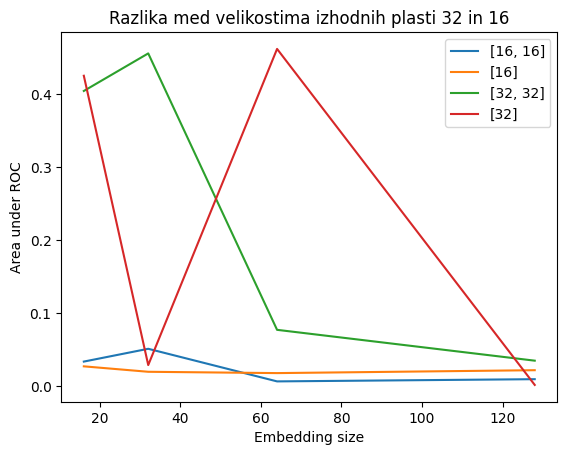

In [89]:
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    criterion2 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 16)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty or GNN_results[criterion2].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"].array
        - GNN_results[criterion2]["area_under_roc"].array,
        label=h,
    )
plt.legend()
plt.title("Razlika med velikostima izhodnih plasti 32 in 16")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

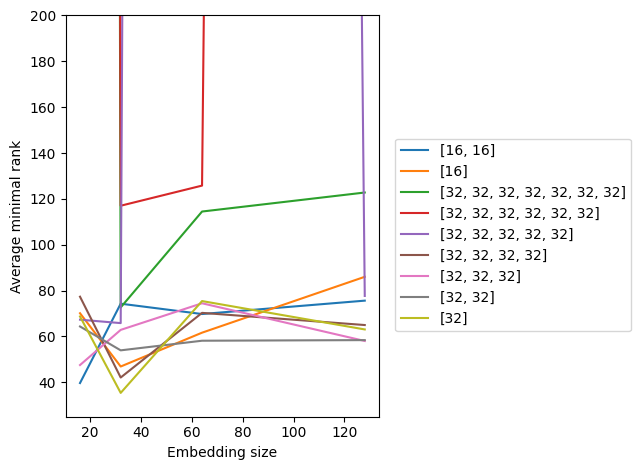

In [90]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal rank")
plt.ylim(25, 200)
# ax.set_yscale('log')

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

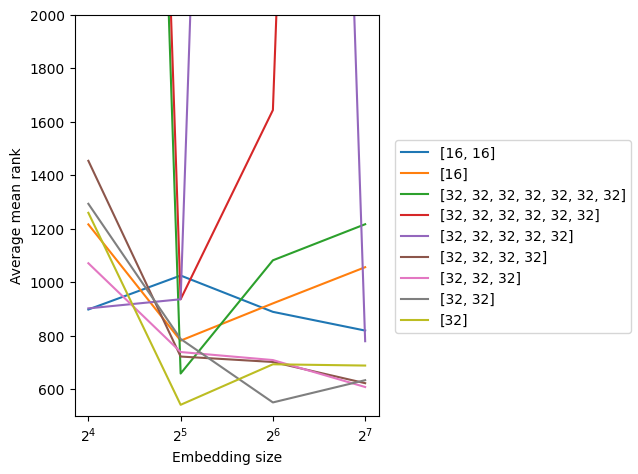

In [91]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        # & (GNN_results["out_size"] != 16)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average mean rank")
plt.ylim(500, 2000)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
ax.set_xscale("log", base=2)
plt.show()

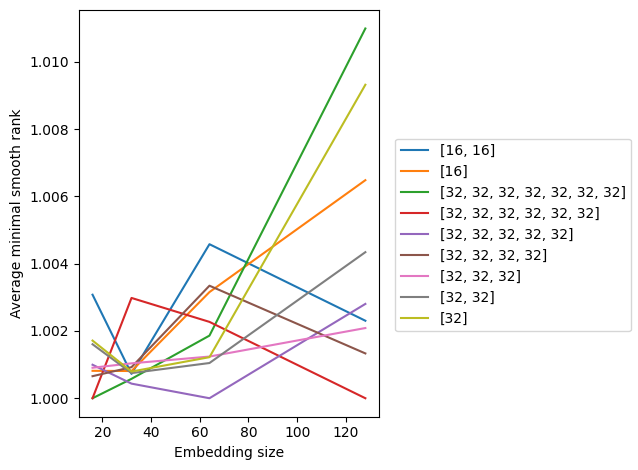

In [92]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_smooth_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

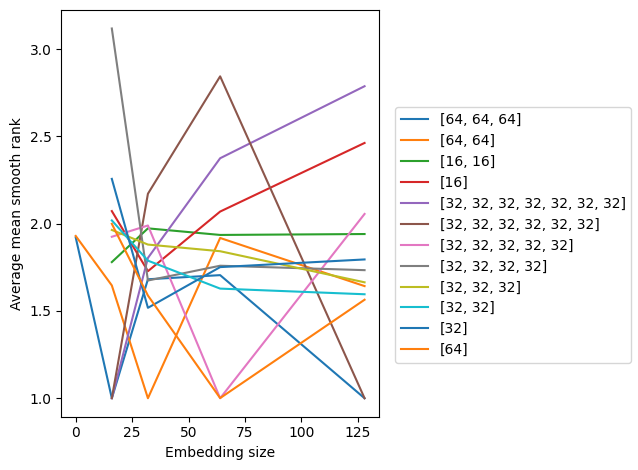

In [93]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] != 16)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_smooth_rank"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average mean smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

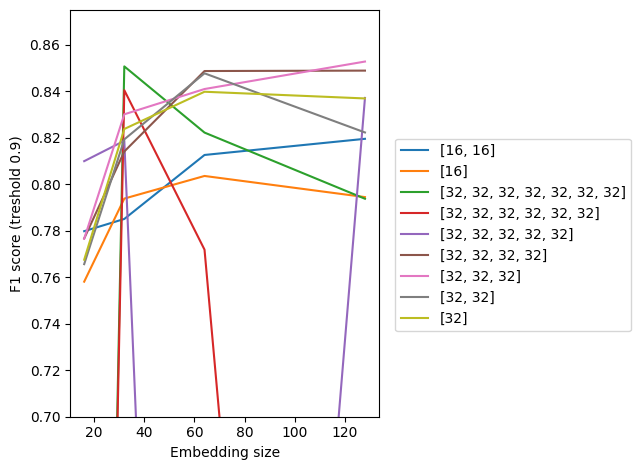

In [94]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for h in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == h)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["f1_0.9"],
        label=h,
    )
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("F1 score (treshold 0.9)")
plt.ylim(0.7, 0.875)

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

Text(0, 0.5, 'Area under ROC')

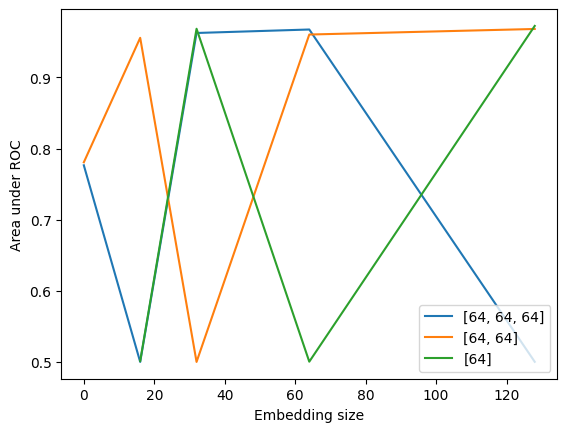

In [95]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["area_under_roc"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Area under ROC")

Text(0, 0.5, 'Average minimal rank')

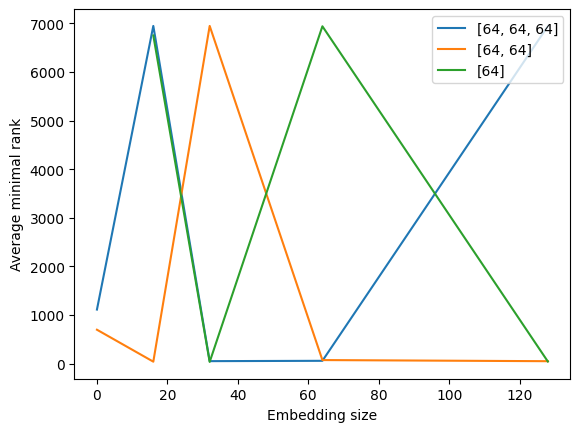

In [96]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_rank"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal rank")

Text(0, 0.5, 'Average mean rank')

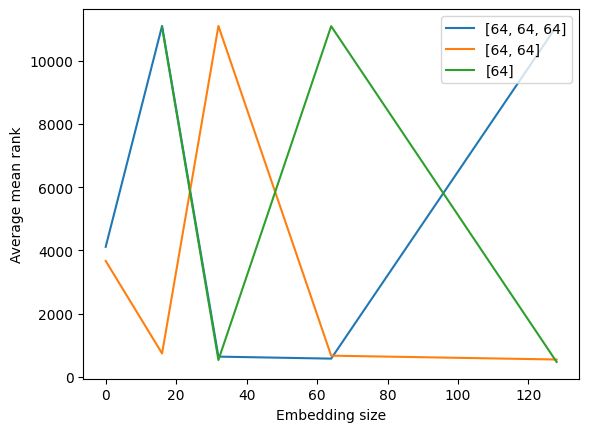

In [97]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_rank"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average mean rank")

(1.0, 1.005)

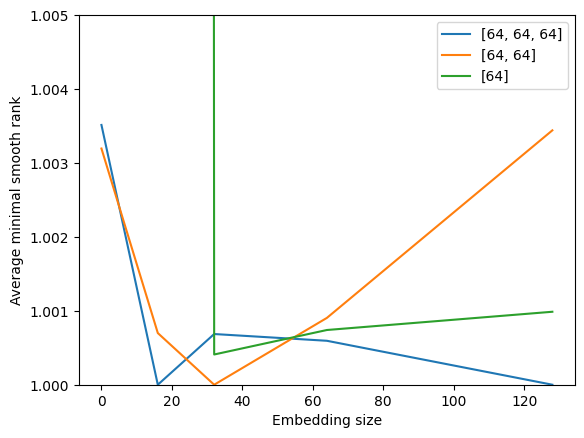

In [98]:
for N in GNN_results.hidden_size.unique():
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 64)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_smooth_rank"],
        label=N,
    )
plt.legend()
plt.title("")
plt.xlabel("Embedding size")
plt.ylabel("Average minimal smooth rank")
plt.ylim(1.0, 1.005)

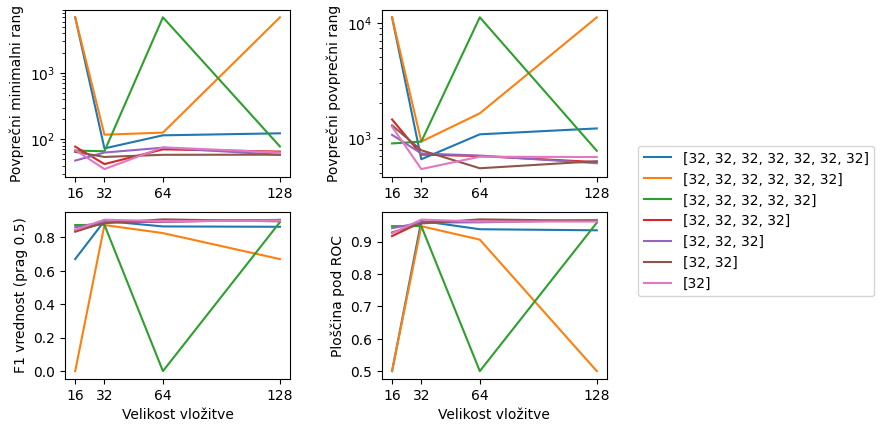

In [99]:
cases = {
    N: (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    for N in GNN_results.hidden_size.unique()
    if "32" in N
}

plot_main_four(
    GNN_results,
    cases,
    "gnn-hidden-layers-number-influence",
    y_scales=[["log", "log"], ["linear", "linear"]],
    legend_position=(1.4, 0.7),
)

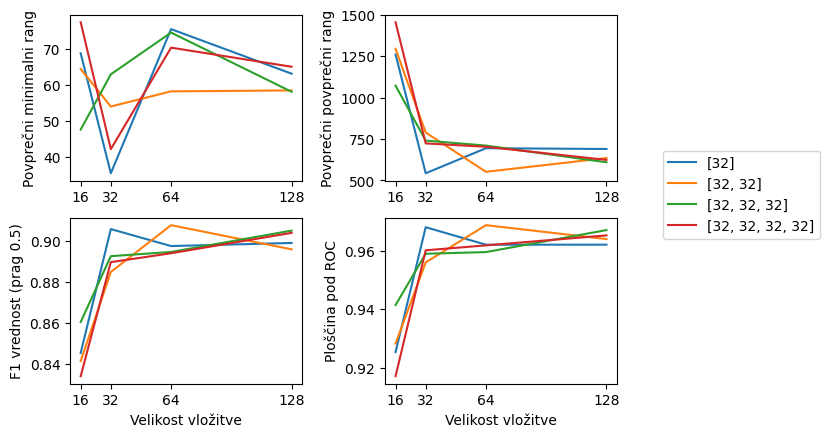

In [100]:
cases = {
    N: (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    for N in ["[32]", "[32, 32]", "[32, 32, 32]", "[32, 32, 32, 32]"]
}

plot_main_four(
    GNN_results,
    cases,
    "gnn-hidden-layers-number-influence-smaller",
    y_scales=[["linear", "linear"], ["linear", "linear"]],
    legend_position=(1.3, 0.7),
)

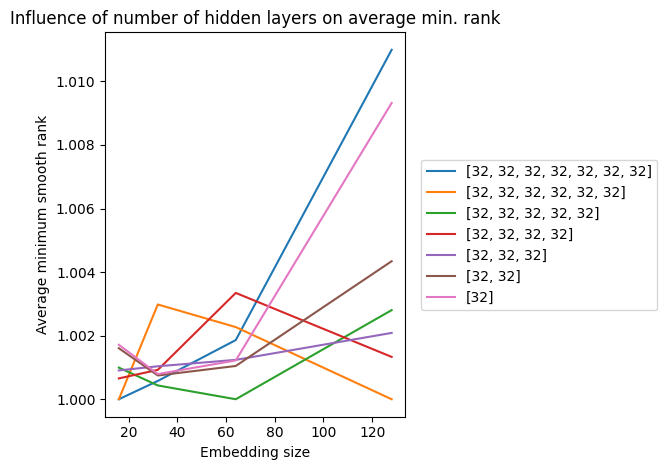

In [101]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_min_smooth_rank"],
        label=N,
    )
plt.title("Influence of number of hidden layers on average min. rank")
plt.xlabel("Embedding size")
plt.ylabel("Average minimum smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

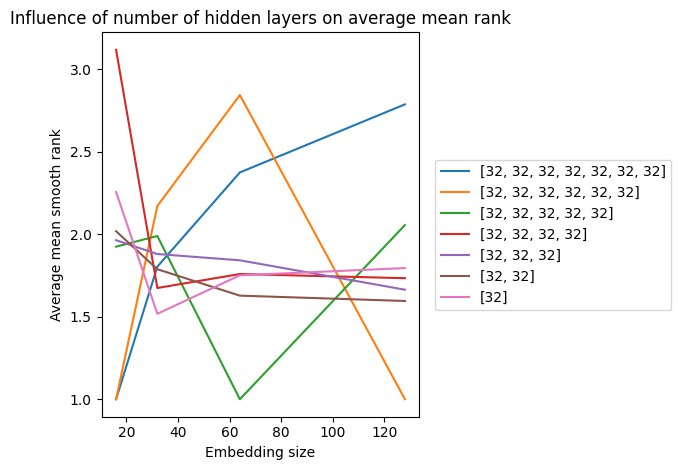

In [102]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
for N in GNN_results.hidden_size.unique():
    if not "32" in N:
        continue
    criterion1 = (
        (GNN_results["hidden_size"] == N)
        & (GNN_results["out_size"] == 32)
        & (GNN_results["n_epochs"] == 20000)
    )
    if GNN_results[criterion1].empty:
        continue
    ax.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1]["avg_mean_smooth_rank"],
        label=N,
    )

plt.title("Influence of number of hidden layers on average mean rank")
plt.xlabel("Embedding size")
plt.ylabel("Average mean smooth rank")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.6)
plt.show()

## F1 scores of chosen models


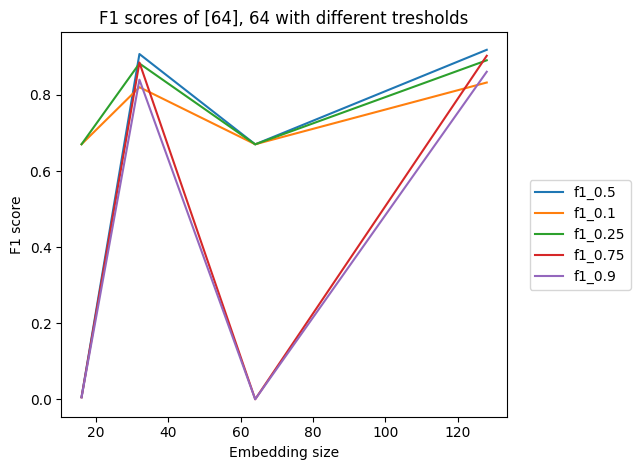

In [103]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[64]")
    & (GNN_results["out_size"] == 64)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [64], 64 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

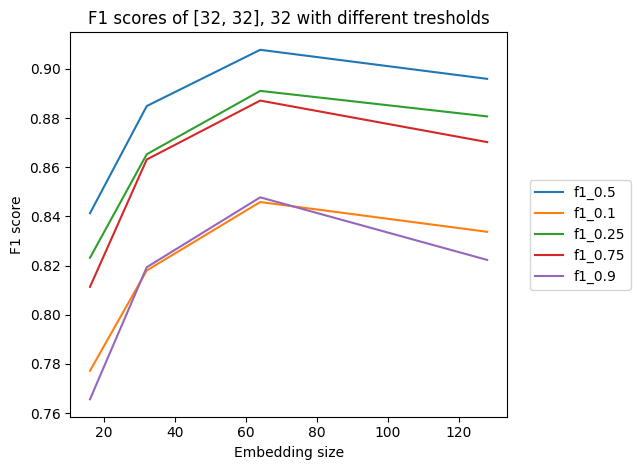

In [104]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[32, 32]")
    & (GNN_results["out_size"] == 32)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [32, 32], 32 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

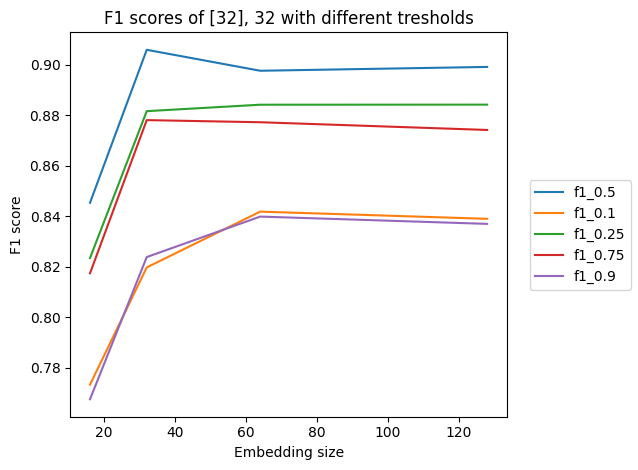

In [105]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[32]")
    & (GNN_results["out_size"] == 32)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [32], 32 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()

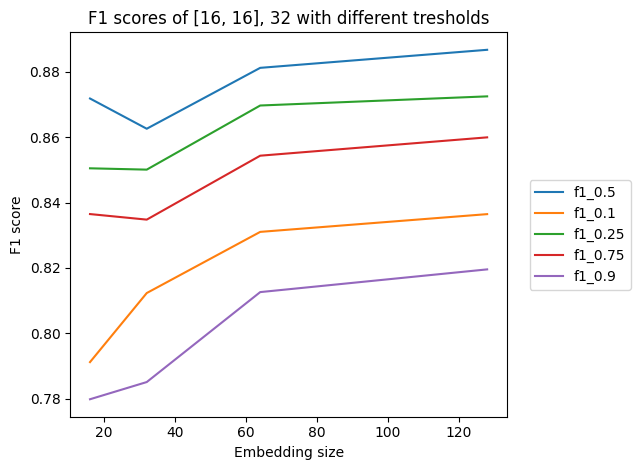

In [106]:
fig, ax = plt.subplots(ncols=1)
ax = plt.subplot(111)
criterion1 = (
    (GNN_results["hidden_size"] == "[16, 16]")
    & (GNN_results["out_size"] == 32)
    & (GNN_results["n_epochs"] == 20000)
)
for s in GNN_results.columns:
    if not "f1_" in str(s):
        continue
    plt.plot(
        GNN_results[criterion1]["embeddings_size"],
        GNN_results[criterion1][s],
        label=s,
    )
plt.title("F1 scores of [16, 16], 32 with different tresholds")
plt.xlabel("Embedding size")
plt.ylabel("F1 score")

fig.legend(loc=5)
fig.tight_layout()
fig.subplots_adjust(right=0.8)
plt.show()